# Supervised Image Classification with CNN and Data Augmentation

This notebook implements a supervised classification model using CNN with transfer learning to classify e-commerce product images into their respective categories.

## Import Libraries

In [2]:
!pip install opencv-python

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

ModuleNotFoundError: No module named 'cv2'

## Load and Prepare Data

In [ ]:
# Load the dataset
data = pd.read_csv('data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df = data.copy()

# Extract category from product_category_tree
df['categorie'] = df['product_category_tree'].str.replace(r'^\s*\[\s*"', '', regex=True).str.split('>>').str[0].str.strip()

print(f"Dataset shape: {df.shape}")
print(f"\nCategory distribution:")
print(df['categorie'].value_counts())

Dataset shape: (1050, 16)

Category distribution:
categorie
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [ ]:
# Configuration
IMAGE_SIZE = (224, 224)
IMAGE_PATH = 'data/Flipkart/Images/complete_dataset'

def load_and_preprocess_image(image_name, target_size=IMAGE_SIZE):
    """Load and preprocess a single image"""
    img_path = os.path.join(IMAGE_PATH, image_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        return img_array
    except Exception as e:
        print(f"Error loading {image_name}: {e}")
        return None

# Load all images
print("Loading images...")
images = []
valid_indices = []

for i, (idx, row) in enumerate(df.iterrows()):
    print(f'\r{i+1}/{len(df)}', end='')
    img = load_and_preprocess_image(row['image'])
    if img is not None:
        images.append(img)
        valid_indices.append(idx)

X = np.array(images)
print(f"\nLoaded {len(X)} images with shape: {X.shape}")

Loading images...

1/1050
2/1050
3/1050
4/1050
5/1050


6/1050
7/1050
8/1050
9/1050
10/1050
11/1050
12/1050
13/1050
14/1050
15/1050
16/1050
17/1050
18/1050
19/1050
20/1050
21/1050
22/1050
23/1050
24/1050
25/1050
26/1050
27/1050
28/1050
29/1050
30/1050
31/1050
32/1050


33/1050
34/1050
35/1050
36/1050
37/1050
38/1050
39/1050
40/1050
41/1050
42/1050
43/1050
44/1050
45/1050
46/1050
47/1050
48/1050
49/1050
50/1050
51/1050
52/1050
53/1050


54/1050
55/1050
56/1050
57/1050
58/1050
59/1050
60/1050
61/1050
62/1050
63/1050
64/1050
65/1050
66/1050
67/1050
68/1050
69/1050
70/1050


71/1050
72/1050
73/1050
74/1050
75/1050
76/1050
77/1050
78/1050
79/1050
80/1050
81/1050


82/1050
83/1050
84/1050
85/1050
86/1050
87/1050
88/1050
89/1050
90/1050
91/1050
92/1050
93/1050
94/1050


95/1050
96/1050
97/1050
98/1050
99/1050
100/1050
101/1050
102/1050
103/1050
104/1050
105/1050
106/1050


107/1050
108/1050
109/1050
110/1050
111/1050
112/1050
113/1050
114/1050
115/1050
116/1050
117/1050


118/1050
119/1050
120/1050
121/1050
122/1050
123/1050
124/1050
125/1050
126/1050
127/1050


128/1050
129/1050
130/1050
131/1050
132/1050
133/1050
134/1050
135/1050
136/1050
137/1050
138/1050
139/1050
140/1050
141/1050
142/1050
143/1050
144/1050
145/1050
146/1050
147/1050
148/1050
149/1050
150/1050


151/1050
152/1050
153/1050
154/1050
155/1050
156/1050
157/1050
158/1050
159/1050
160/1050
161/1050
162/1050
163/1050
164/1050
165/1050
166/1050
167/1050
168/1050
169/1050
170/1050
171/1050
172/1050


173/1050
174/1050
175/1050
176/1050
177/1050
178/1050
179/1050
180/1050
181/1050
182/1050
183/1050
184/1050
185/1050
186/1050
187/1050
188/1050
189/1050
190/1050
191/1050
192/1050
193/1050
194/1050
195/1050


196/1050
197/1050
198/1050
199/1050
200/1050
201/1050
202/1050
203/1050


204/1050
205/1050
206/1050
207/1050
208/1050
209/1050
210/1050
211/1050
212/1050
213/1050
214/1050
215/1050
216/1050
217/1050
218/1050
219/1050


220/1050
221/1050
222/1050
223/1050
224/1050
225/1050
226/1050
227/1050
228/1050
229/1050
230/1050
231/1050
232/1050
233/1050
234/1050
235/1050
236/1050
237/1050
238/1050
239/1050


240/1050
241/1050
242/1050
243/1050
244/1050
245/1050
246/1050
247/1050
248/1050
249/1050
250/1050
251/1050
252/1050
253/1050
254/1050
255/1050


256/1050
257/1050
258/1050
259/1050
260/1050
261/1050
262/1050
263/1050
264/1050
265/1050
266/1050
267/1050
268/1050


269/1050
270/1050
271/1050
272/1050
273/1050
274/1050
275/1050
276/1050
277/1050
278/1050
279/1050
280/1050
281/1050
282/1050


283/1050
284/1050
285/1050
286/1050
287/1050
288/1050
289/1050
290/1050


291/1050
292/1050
293/1050
294/1050
295/1050
296/1050
297/1050
298/1050
299/1050
300/1050
301/1050
302/1050
303/1050


304/1050
305/1050
306/1050
307/1050
308/1050
309/1050
310/1050
311/1050
312/1050
313/1050
314/1050
315/1050
316/1050
317/1050
318/1050
319/1050
320/1050
321/1050


322/1050
323/1050
324/1050
325/1050
326/1050
327/1050
328/1050
329/1050
330/1050
331/1050
332/1050
333/1050
334/1050
335/1050
336/1050
337/1050
338/1050
339/1050
340/1050
341/1050
342/1050
343/1050
344/1050
345/1050


346/1050
347/1050
348/1050
349/1050
350/1050
351/1050
352/1050
353/1050
354/1050
355/1050
356/1050
357/1050
358/1050
359/1050
360/1050
361/1050
362/1050
363/1050
364/1050
365/1050
366/1050
367/1050
368/1050
369/1050


370/1050
371/1050
372/1050
373/1050
374/1050
375/1050
376/1050
377/1050
378/1050
379/1050
380/1050
381/1050
382/1050
383/1050
384/1050
385/1050
386/1050


387/1050
388/1050
389/1050
390/1050
391/1050
392/1050
393/1050
394/1050
395/1050
396/1050
397/1050


398/1050
399/1050
400/1050
401/1050
402/1050
403/1050
404/1050
405/1050
406/1050
407/1050
408/1050
409/1050
410/1050
411/1050
412/1050
413/1050
414/1050
415/1050
416/1050
417/1050
418/1050
419/1050
420/1050


421/1050
422/1050
423/1050
424/1050
425/1050
426/1050
427/1050
428/1050
429/1050
430/1050
431/1050
432/1050
433/1050
434/1050
435/1050
436/1050
437/1050
438/1050
439/1050
440/1050
441/1050
442/1050
443/1050
444/1050


445/1050
446/1050
447/1050
448/1050
449/1050
450/1050
451/1050
452/1050
453/1050
454/1050
455/1050
456/1050
457/1050
458/1050
459/1050
460/1050
461/1050
462/1050
463/1050


464/1050
465/1050
466/1050
467/1050
468/1050
469/1050


470/1050
471/1050
472/1050
473/1050
474/1050
475/1050
476/1050
477/1050
478/1050
479/1050
480/1050
481/1050
482/1050
483/1050
484/1050
485/1050
486/1050
487/1050
488/1050
489/1050
490/1050
491/1050
492/1050
493/1050
494/1050


495/1050
496/1050
497/1050
498/1050
499/1050
500/1050
501/1050
502/1050
503/1050
504/1050
505/1050
506/1050
507/1050
508/1050
509/1050
510/1050
511/1050
512/1050
513/1050
514/1050
515/1050
516/1050


517/1050
518/1050
519/1050
520/1050
521/1050
522/1050
523/1050
524/1050
525/1050
526/1050
527/1050
528/1050
529/1050
530/1050
531/1050
532/1050
533/1050
534/1050
535/1050
536/1050
537/1050
538/1050
539/1050
540/1050


541/1050
542/1050
543/1050
544/1050
545/1050
546/1050
547/1050
548/1050
549/1050
550/1050
551/1050
552/1050
553/1050
554/1050
555/1050
556/1050
557/1050
558/1050
559/1050
560/1050
561/1050
562/1050
563/1050
564/1050
565/1050
566/1050
567/1050
568/1050
569/1050
570/1050
571/1050
572/1050
573/1050
574/1050
575/1050
576/1050
577/1050


578/1050
579/1050
580/1050
581/1050
582/1050
583/1050
584/1050
585/1050
586/1050
587/1050
588/1050
589/1050
590/1050
591/1050
592/1050
593/1050
594/1050
595/1050


596/1050
597/1050
598/1050
599/1050
600/1050
601/1050
602/1050
603/1050
604/1050
605/1050
606/1050
607/1050
608/1050
609/1050


610/1050
611/1050
612/1050
613/1050
614/1050
615/1050
616/1050
617/1050
618/1050
619/1050
620/1050
621/1050
622/1050
623/1050
624/1050
625/1050
626/1050
627/1050
628/1050


629/1050
630/1050
631/1050
632/1050
633/1050
634/1050
635/1050
636/1050
637/1050
638/1050
639/1050
640/1050
641/1050


642/1050
643/1050
644/1050
645/1050
646/1050
647/1050
648/1050
649/1050
650/1050
651/1050
652/1050
653/1050
654/1050
655/1050
656/1050


657/1050
658/1050
659/1050
660/1050
661/1050
662/1050
663/1050
664/1050
665/1050
666/1050
667/1050
668/1050
669/1050
670/1050
671/1050
672/1050
673/1050


674/1050
675/1050
676/1050
677/1050
678/1050

/Users/j/Documents/OC_Inge_IA/Projet_6/.venv/lib/python3.11/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



679/1050
680/1050
681/1050
682/1050
683/1050
684/1050
685/1050
686/1050
687/1050
688/1050
689/1050
690/1050
691/1050
692/1050


693/1050
694/1050
695/1050
696/1050
697/1050
698/1050
699/1050
700/1050
701/1050
702/1050


703/1050
704/1050
705/1050
706/1050
707/1050
708/1050
709/1050


710/1050
711/1050
712/1050
713/1050
714/1050
715/1050
716/1050
717/1050
718/1050
719/1050
720/1050


721/1050
722/1050
723/1050
724/1050
725/1050
726/1050
727/1050
728/1050
729/1050
730/1050
731/1050
732/1050
733/1050


734/1050
735/1050
736/1050
737/1050
738/1050
739/1050
740/1050
741/1050
742/1050
743/1050
744/1050
745/1050
746/1050
747/1050
748/1050
749/1050
750/1050
751/1050


752/1050
753/1050
754/1050
755/1050
756/1050
757/1050
758/1050


759/1050
760/1050
761/1050
762/1050
763/1050
764/1050
765/1050
766/1050
767/1050
768/1050
769/1050
770/1050
771/1050
772/1050
773/1050
774/1050
775/1050
776/1050
777/1050


778/1050
779/1050
780/1050
781/1050
782/1050
783/1050
784/1050
785/1050
786/1050
787/1050
788/1050
789/1050
790/1050


791/1050
792/1050
793/1050
794/1050
795/1050
796/1050
797/1050
798/1050
799/1050
800/1050
801/1050
802/1050
803/1050
804/1050
805/1050
806/1050
807/1050
808/1050
809/1050
810/1050
811/1050
812/1050
813/1050
814/1050
815/1050


816/1050
817/1050
818/1050
819/1050
820/1050
821/1050
822/1050
823/1050
824/1050
825/1050
826/1050
827/1050
828/1050
829/1050
830/1050


831/1050
832/1050
833/1050
834/1050
835/1050
836/1050
837/1050
838/1050
839/1050
840/1050
841/1050
842/1050
843/1050
844/1050
845/1050
846/1050
847/1050
848/1050
849/1050
850/1050
851/1050
852/1050
853/1050
854/1050
855/1050


856/1050
857/1050
858/1050
859/1050
860/1050
861/1050
862/1050
863/1050
864/1050
865/1050
866/1050
867/1050
868/1050
869/1050


870/1050
871/1050
872/1050
873/1050
874/1050
875/1050
876/1050
877/1050
878/1050
879/1050
880/1050
881/1050
882/1050
883/1050


884/1050
885/1050
886/1050
887/1050
888/1050
889/1050
890/1050


891/1050
892/1050
893/1050
894/1050
895/1050
896/1050
897/1050
898/1050
899/1050
900/1050
901/1050
902/1050
903/1050


904/1050
905/1050
906/1050
907/1050
908/1050
909/1050
910/1050
911/1050
912/1050
913/1050
914/1050


915/1050
916/1050
917/1050
918/1050
919/1050
920/1050
921/1050
922/1050
923/1050
924/1050
925/1050
926/1050
927/1050


928/1050
929/1050
930/1050
931/1050
932/1050
933/1050
934/1050
935/1050
936/1050
937/1050


938/1050
939/1050
940/1050
941/1050
942/1050
943/1050
944/1050
945/1050
946/1050
947/1050


948/1050
949/1050
950/1050
951/1050
952/1050
953/1050
954/1050
955/1050
956/1050
957/1050
958/1050
959/1050


960/1050
961/1050
962/1050
963/1050
964/1050
965/1050


966/1050
967/1050
968/1050
969/1050
970/1050


971/1050
972/1050
973/1050
974/1050
975/1050
976/1050
977/1050
978/1050
979/1050
980/1050
981/1050
982/1050


983/1050
984/1050
985/1050
986/1050
987/1050
988/1050
989/1050
990/1050


991/1050
992/1050
993/1050
994/1050


995/1050
996/1050
997/1050
998/1050
999/1050
1000/1050
1001/1050
1002/1050
1003/1050
1004/1050
1005/1050
1006/1050
1007/1050
1008/1050
1009/1050
1010/1050
1011/1050
1012/1050


1013/1050
1014/1050
1015/1050
1016/1050
1017/1050
1018/1050
1019/1050
1020/1050
1021/1050
1022/1050
1023/1050
1024/1050
1025/1050


1026/1050
1027/1050
1028/1050
1029/1050
1030/1050
1031/1050
1032/1050
1033/1050


1034/1050
1035/1050
1036/1050
1037/1050
1038/1050


1039/1050
1040/1050
1041/1050
1042/1050
1043/1050
1044/1050
1045/1050
1046/1050


1047/1050
1048/1050
1049/1050
1050/1050
Loaded 1050 images with shape: (1050, 224, 224, 3)


In [ ]:
# Prepare labels
df_valid = df.loc[valid_indices]
le = LabelEncoder()
y_encoded = le.fit_transform(df_valid['categorie'])
y = to_categorical(y_encoded)

n_classes = len(le.classes_)
print(f"Number of classes: {n_classes}")
print(f"Classes: {le.classes_}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Number of classes: 7
Classes: ['Baby Care' 'Beauty and Personal Care' 'Computers'
 'Home Decor & Festive Needs' 'Home Furnishing' 'Kitchen & Dining'
 'Watches']
X shape: (1050, 224, 224, 3), y shape: (1050, 7)


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 840 samples
Test set: 210 samples


## Data Augmentation

Data augmentation increases the effective size of the training dataset by applying random transformations to images during training. This helps prevent overfitting and improves model generalization.

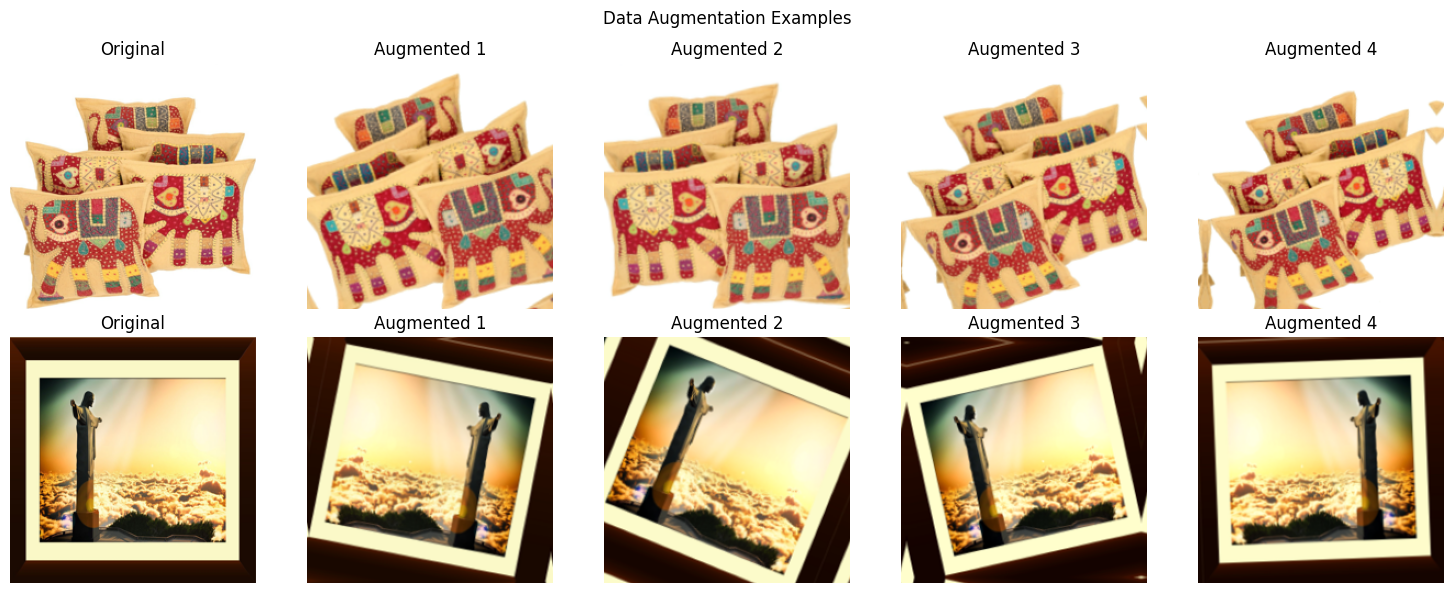

In [ ]:
# Define data augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
], name='data_augmentation')

# Visualize augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
original_img = X_train[0:1]

axes[0, 0].imshow(original_img[0].astype(np.uint8))
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i in range(1, 5):
    augmented = data_augmentation(original_img)
    axes[0, i].imshow(augmented[0].numpy().astype(np.uint8))
    axes[0, i].set_title(f'Augmented {i}')
    axes[0, i].axis('off')

original_img2 = X_train[10:11]
axes[1, 0].imshow(original_img2[0].astype(np.uint8))
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

for i in range(1, 5):
    augmented = data_augmentation(original_img2)
    axes[1, i].imshow(augmented[0].numpy().astype(np.uint8))
    axes[1, i].set_title(f'Augmented {i}')
    axes[1, i].axis('off')

plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
plt.show()

## Build CNN Model with Transfer Learning

We use VGG16 pre-trained on ImageNet as a feature extractor, then add custom classification layers on top.

In [ ]:
def build_model(n_classes, input_shape=(224, 224, 3)):
    """
    Build CNN model with VGG16 transfer learning and data augmentation
    """
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Build the complete model
    inputs = tf.keras.Input(shape=input_shape)
    
    # Data augmentation (only during training)
    x = data_augmentation(inputs)
    
    # Preprocess for VGG16
    x = tf.keras.applications.vgg16.preprocess_input(x)
    
    # Base model
    x = base_model(x, training=False)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model, base_model

# Build the model
model, base_model = build_model(n_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        903 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,880,839 (56.77 MB)

 Trainable params: 165,639 (647.03 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

## Training Phase 1: Train Classification Head (Frozen Base)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train Phase 1: Only classification head
EPOCHS_PHASE1 = 20
BATCH_SIZE = 32

print("Phase 1: Training classification head with frozen base model...")
history1 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Phase 1: Training classification head with frozen base model...
Epoch 1/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:18 4s/step - accuracy: 0.0938 - loss: 3.1210


 2/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.1172 - loss: 3.1616 


 3/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1163 - loss: 3.1443


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.1146 - loss: 3.1104


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1154 - loss: 3.0695


 6/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.1222 - loss: 3.0195


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.1284 - loss: 2.9696


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1348 - loss: 2.9229


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1414 - loss: 2.8813


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1491 - loss: 2.8414


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1565 - loss: 2.8057


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1632 - loss: 2.7738


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1699 - loss: 2.7443


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.1767 - loss: 2.7143


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1837 - loss: 2.6842


16/21 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1905 - loss: 2.6552


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1968 - loss: 2.6273 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2034 - loss: 2.5989


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2098 - loss: 2.5724


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2160 - loss: 2.5464


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2224 - loss: 2.5205


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.3497 - loss: 2.0033 - val_accuracy: 0.6905 - val_loss: 1.2208 - learning_rate: 0.0010


Epoch 2/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5938 - loss: 1.1654


 2/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.6016 - loss: 1.1298


 3/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6128 - loss: 1.1161


 4/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6237 - loss: 1.0956


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6277 - loss: 1.0872


 6/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6273 - loss: 1.0836


 7/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6263 - loss: 1.0881


 8/21 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6276 - loss: 1.0913


 9/21 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6289 - loss: 1.0914


10/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6307 - loss: 1.0900


11/21 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6327 - loss: 1.0882


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6343 - loss: 1.0867


13/21 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6354 - loss: 1.0853


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6362 - loss: 1.0855


15/21 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.6372 - loss: 1.0851


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6379 - loss: 1.0839


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6384 - loss: 1.0840


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.6388 - loss: 1.0839 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6397 - loss: 1.0833


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.6402 - loss: 1.0829


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6412 - loss: 1.0815


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.6592 - loss: 1.0538 - val_accuracy: 0.7798 - val_loss: 0.7612 - learning_rate: 0.0010


Epoch 3/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7500 - loss: 0.9384


 2/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7344 - loss: 0.9078


 3/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7361 - loss: 0.8701


 4/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7396 - loss: 0.8425


 5/21 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7379 - loss: 0.8362


 6/21 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7365 - loss: 0.8266


 7/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7333 - loss: 0.8245


 8/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.7276 - loss: 0.8382


 9/21 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7239 - loss: 0.8461


10/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7212 - loss: 0.8497


11/21 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7181 - loss: 0.8555


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7160 - loss: 0.8604


13/21 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7151 - loss: 0.8620


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7147 - loss: 0.8628


15/21 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7146 - loss: 0.8625


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7140 - loss: 0.8644


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.7136 - loss: 0.8661


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7135 - loss: 0.8672 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7134 - loss: 0.8685


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.7133 - loss: 0.8694


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7135 - loss: 0.8699


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.7173 - loss: 0.8802 - val_accuracy: 0.8214 - val_loss: 0.5613 - learning_rate: 0.0010


Epoch 4/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7812 - loss: 0.7896


 2/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7656 - loss: 0.8470


 3/21 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7812 - loss: 0.8280


 4/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7871 - loss: 0.8154


 5/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7872 - loss: 0.8103


 6/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7862 - loss: 0.8043


 7/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7855 - loss: 0.7958


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7874 - loss: 0.7820


 9/21 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7879 - loss: 0.7743


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7878 - loss: 0.7692


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7880 - loss: 0.7646


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7883 - loss: 0.7613


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7891 - loss: 0.7560


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7887 - loss: 0.7530


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7885 - loss: 0.7494


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7884 - loss: 0.7458


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7882 - loss: 0.7437 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7878 - loss: 0.7423


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7878 - loss: 0.7402


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7876 - loss: 0.7388


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7876 - loss: 0.7366


21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.7872 - loss: 0.6928 - val_accuracy: 0.8512 - val_loss: 0.5040 - learning_rate: 0.0010


Epoch 5/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7500 - loss: 0.7027


 2/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7500 - loss: 0.6909


 3/21 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7569 - loss: 0.6704


 4/21 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.7572 - loss: 0.6565


 5/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7607 - loss: 0.6454


 6/21 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7615 - loss: 0.6441


 7/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7612 - loss: 0.6442


 8/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7603 - loss: 0.6413


 9/21 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7584 - loss: 0.6410


10/21 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7581 - loss: 0.6382


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7582 - loss: 0.6372


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7579 - loss: 0.6375


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7579 - loss: 0.6391


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7583 - loss: 0.6394


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7591 - loss: 0.6390


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7601 - loss: 0.6383


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7613 - loss: 0.6372 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7623 - loss: 0.6365


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7635 - loss: 0.6351


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7645 - loss: 0.6344


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7654 - loss: 0.6334


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.7827 - loss: 0.6152 - val_accuracy: 0.8571 - val_loss: 0.4486 - learning_rate: 0.0010


Epoch 6/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8750 - loss: 0.4433


 2/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8594 - loss: 0.4717


 3/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8542 - loss: 0.4886


 4/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8516 - loss: 0.5008


 5/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8450 - loss: 0.5151


 6/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8387 - loss: 0.5222


 7/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8331 - loss: 0.5305


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8300 - loss: 0.5343


 9/21 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8288 - loss: 0.5348


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8281 - loss: 0.5354


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8272 - loss: 0.5380


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8267 - loss: 0.5393


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8257 - loss: 0.5404


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8250 - loss: 0.5418


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8244 - loss: 0.5422


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8239 - loss: 0.5421


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8237 - loss: 0.5419 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8230 - loss: 0.5432


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8221 - loss: 0.5454


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8210 - loss: 0.5482


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8200 - loss: 0.5505


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8006 - loss: 0.5952 - val_accuracy: 0.8631 - val_loss: 0.4788 - learning_rate: 0.0010


Epoch 7/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.7812 - loss: 0.6231


 2/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7969 - loss: 0.5664


 3/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8056 - loss: 0.5500


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8151 - loss: 0.5270


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8196 - loss: 0.5098


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8149 - loss: 0.5156


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8114 - loss: 0.5212


 8/21 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8106 - loss: 0.5226


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8100 - loss: 0.5244


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8078 - loss: 0.5317


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8059 - loss: 0.5379


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8045 - loss: 0.5434


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8030 - loss: 0.5475


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8021 - loss: 0.5500


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8013 - loss: 0.5518


16/21 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8005 - loss: 0.5534


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8004 - loss: 0.5537 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8001 - loss: 0.5541


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7998 - loss: 0.5546


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7994 - loss: 0.5552


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7990 - loss: 0.5563


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.7902 - loss: 0.5784 - val_accuracy: 0.8631 - val_loss: 0.4414 - learning_rate: 0.0010


Epoch 8/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6562 - loss: 1.2198


 2/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7031 - loss: 1.0788


 3/21 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7292 - loss: 0.9742


 4/21 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7461 - loss: 0.9010


 5/21 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7594 - loss: 0.8454


 6/21 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7708 - loss: 0.8003


 7/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7800 - loss: 0.7628


 8/21 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7870 - loss: 0.7348


 9/21 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7929 - loss: 0.7121


10/21 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7967 - loss: 0.6934


11/21 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8000 - loss: 0.6771


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8032 - loss: 0.6625


13/21 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8061 - loss: 0.6495


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8085 - loss: 0.6395


15/21 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8103 - loss: 0.6310


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8118 - loss: 0.6232


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8129 - loss: 0.6166


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8137 - loss: 0.6108 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8147 - loss: 0.6057


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8156 - loss: 0.6013


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8165 - loss: 0.5969


21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8333 - loss: 0.5104 - val_accuracy: 0.8631 - val_loss: 0.4546 - learning_rate: 0.0010


Epoch 9/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7188 - loss: 0.8770


 2/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7656 - loss: 0.7652


 3/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7812 - loss: 0.7049


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7891 - loss: 0.6640


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7962 - loss: 0.6351


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8016 - loss: 0.6144


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8076 - loss: 0.5989


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8131 - loss: 0.5865


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8177 - loss: 0.5755


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8221 - loss: 0.5647


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8254 - loss: 0.5565


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8282 - loss: 0.5484


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8302 - loss: 0.5425


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8321 - loss: 0.5367


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8338 - loss: 0.5311


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8354 - loss: 0.5262


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8369 - loss: 0.5215 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8380 - loss: 0.5177


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8391 - loss: 0.5139


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8399 - loss: 0.5108


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8405 - loss: 0.5080


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8527 - loss: 0.4518 - val_accuracy: 0.8631 - val_loss: 0.4701 - learning_rate: 0.0010


Epoch 10/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8750 - loss: 0.3887


 2/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8594 - loss: 0.4058


 3/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8611 - loss: 0.3897


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8646 - loss: 0.3798


 5/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8679 - loss: 0.3756


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8708 - loss: 0.3718


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8727 - loss: 0.3690


 8/21 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8735 - loss: 0.3676


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8740 - loss: 0.3678


10/21 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8744 - loss: 0.3681


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8750 - loss: 0.3682


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8759 - loss: 0.3681


13/21 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8764 - loss: 0.3679


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8769 - loss: 0.3674


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8778 - loss: 0.3668


16/21 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8784 - loss: 0.3661


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8789 - loss: 0.3656 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8791 - loss: 0.3652


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8795 - loss: 0.3645


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8799 - loss: 0.3642


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8802 - loss: 0.3637


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.8869 - loss: 0.3543 - val_accuracy: 0.8810 - val_loss: 0.4477 - learning_rate: 0.0010


Epoch 11/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9062 - loss: 0.4021


 2/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9062 - loss: 0.3958


 3/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8924 - loss: 0.4207


 4/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8861 - loss: 0.4323


 5/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8814 - loss: 0.4409


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8777 - loss: 0.4456


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8741 - loss: 0.4488


 8/21 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8723 - loss: 0.4509


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8714 - loss: 0.4510


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8715 - loss: 0.4492


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8720 - loss: 0.4462


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8727 - loss: 0.4427


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8735 - loss: 0.4392


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8734 - loss: 0.4366


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8734 - loss: 0.4342


16/21 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8737 - loss: 0.4313


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8740 - loss: 0.4289 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8743 - loss: 0.4268


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8746 - loss: 0.4246


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8751 - loss: 0.4221


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8757 - loss: 0.4195


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8869 - loss: 0.3680 - val_accuracy: 0.8810 - val_loss: 0.4379 - learning_rate: 5.0000e-04


Epoch 12/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9062 - loss: 0.2895


 2/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9062 - loss: 0.2931


 3/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8993 - loss: 0.3247


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8991 - loss: 0.3358


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8968 - loss: 0.3447


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8914 - loss: 0.3566


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8871 - loss: 0.3646


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8822 - loss: 0.3728


 9/21 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8787 - loss: 0.3776


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8752 - loss: 0.3810


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8731 - loss: 0.3826


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8715 - loss: 0.3844


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8707 - loss: 0.3856


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8705 - loss: 0.3852


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8706 - loss: 0.3857


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8705 - loss: 0.3861


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8703 - loss: 0.3865 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8703 - loss: 0.3865


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8702 - loss: 0.3877


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8703 - loss: 0.3884


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8703 - loss: 0.3890


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8705 - loss: 0.4016 - val_accuracy: 0.8810 - val_loss: 0.4276 - learning_rate: 5.0000e-04


Epoch 13/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8750 - loss: 0.2742


 2/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8438 - loss: 0.3624


 3/21 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8403 - loss: 0.3748


 4/21 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8431 - loss: 0.3723


 5/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8420 - loss: 0.3724


 6/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8414 - loss: 0.3744


 7/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8405 - loss: 0.3773


 8/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8399 - loss: 0.3801


 9/21 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8396 - loss: 0.3821


10/21 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8394 - loss: 0.3828


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8398 - loss: 0.3825


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8403 - loss: 0.3813


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8409 - loss: 0.3798


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8419 - loss: 0.3774


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8434 - loss: 0.3741


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8450 - loss: 0.3709


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8466 - loss: 0.3682 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8482 - loss: 0.3655


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8496 - loss: 0.3635


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8509 - loss: 0.3616


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8520 - loss: 0.3599


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8735 - loss: 0.3259 - val_accuracy: 0.8750 - val_loss: 0.4255 - learning_rate: 5.0000e-04


Epoch 14/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9062 - loss: 0.3523


 2/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9141 - loss: 0.3394


 3/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9184 - loss: 0.3294


 4/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9212 - loss: 0.3257


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9220 - loss: 0.3203


 6/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9202 - loss: 0.3193


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9182 - loss: 0.3182


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9158 - loss: 0.3183


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9124 - loss: 0.3201


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9090 - loss: 0.3223


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9054 - loss: 0.3252


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9028 - loss: 0.3265


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9009 - loss: 0.3279


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8989 - loss: 0.3289


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8969 - loss: 0.3304


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8951 - loss: 0.3323


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8938 - loss: 0.3334 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8928 - loss: 0.3342


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8919 - loss: 0.3349


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8912 - loss: 0.3353


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8904 - loss: 0.3358


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8750 - loss: 0.3456 - val_accuracy: 0.8690 - val_loss: 0.4437 - learning_rate: 5.0000e-04


Epoch 15/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8438 - loss: 0.4632


 2/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8594 - loss: 0.4186


 3/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8646 - loss: 0.4040


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8711 - loss: 0.3891


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8756 - loss: 0.3769


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8790 - loss: 0.3680


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8816 - loss: 0.3673


 8/21 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8832 - loss: 0.3656


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8850 - loss: 0.3620


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8871 - loss: 0.3579


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8896 - loss: 0.3529


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8915 - loss: 0.3493


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8930 - loss: 0.3458


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8939 - loss: 0.3429


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8947 - loss: 0.3402


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8952 - loss: 0.3387


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8959 - loss: 0.3369 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8962 - loss: 0.3359


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8964 - loss: 0.3350


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8966 - loss: 0.3344


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8964 - loss: 0.3344


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8929 - loss: 0.3346 - val_accuracy: 0.8690 - val_loss: 0.4395 - learning_rate: 5.0000e-04


Epoch 16/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9062 - loss: 0.2541


 2/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8984 - loss: 0.2603


 3/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8837 - loss: 0.2823


 4/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8796 - loss: 0.2960


 5/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8799 - loss: 0.3019


 6/21 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8791 - loss: 0.3079


 7/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8791 - loss: 0.3117


 8/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8801 - loss: 0.3137


 9/21 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8811 - loss: 0.3135


10/21 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8817 - loss: 0.3138


11/21 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8814 - loss: 0.3147


12/21 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8817 - loss: 0.3142


13/21 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8823 - loss: 0.3135


14/21 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8829 - loss: 0.3126


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8835 - loss: 0.3114


16/21 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8840 - loss: 0.3106


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8845 - loss: 0.3100 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8846 - loss: 0.3096


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8850 - loss: 0.3090


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8851 - loss: 0.3087


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8850 - loss: 0.3089


21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8824 - loss: 0.3119 - val_accuracy: 0.8631 - val_loss: 0.4520 - learning_rate: 5.0000e-04


Epoch 17/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9375 - loss: 0.1706


 2/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9453 - loss: 0.1840


 3/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9531 - loss: 0.1708


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9492 - loss: 0.1716


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9444 - loss: 0.1797


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9398 - loss: 0.1903


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9369 - loss: 0.1986


 8/21 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9350 - loss: 0.2065


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9326 - loss: 0.2133


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9306 - loss: 0.2184


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9291 - loss: 0.2226


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9274 - loss: 0.2273


13/21 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9258 - loss: 0.2312


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9239 - loss: 0.2355


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9223 - loss: 0.2391


16/21 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9210 - loss: 0.2423


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9198 - loss: 0.2450 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9188 - loss: 0.2471


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9182 - loss: 0.2486


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9177 - loss: 0.2495


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9173 - loss: 0.2505


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9092 - loss: 0.2707 - val_accuracy: 0.8690 - val_loss: 0.4540 - learning_rate: 2.5000e-04


Epoch 18/20



 1/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8750 - loss: 0.2502


 2/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8828 - loss: 0.2510


 3/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8802 - loss: 0.2743


 4/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8828 - loss: 0.2846


 5/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8850 - loss: 0.2960


 6/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8877 - loss: 0.2969


 7/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8897 - loss: 0.2989


 8/21 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8903 - loss: 0.3014


 9/21 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8917 - loss: 0.3012


10/21 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8928 - loss: 0.3007


11/21 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8943 - loss: 0.2985


12/21 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8951 - loss: 0.2978


13/21 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8956 - loss: 0.2984


14/21 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8960 - loss: 0.2986


15/21 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8967 - loss: 0.2980


16/21 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8974 - loss: 0.2969


17/21 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8978 - loss: 0.2963 


18/21 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8981 - loss: 0.2961


19/21 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8983 - loss: 0.2963


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8984 - loss: 0.2963


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8987 - loss: 0.2961


21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9048 - loss: 0.2913 - val_accuracy: 0.8690 - val_loss: 0.4611 - learning_rate: 2.5000e-04


## Training Phase 2: Fine-tuning (Unfreeze some layers)

In [ ]:
# Fine-tuning: Unfreeze the last few layers of the base model
base_model.trainable = True

# Freeze all layers except the last 4
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Phase 2: Fine-tuning
EPOCHS_PHASE2 = 10

print("\nPhase 2: Fine-tuning with unfrozen top layers...")
history2 = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Phase 2: Fine-tuning with unfrozen top layers...
Epoch 1/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 1:34 5s/step - accuracy: 0.8125 - loss: 0.4047


 2/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8359 - loss: 0.3762 


 3/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.8455 - loss: 0.3663


 4/21 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8548 - loss: 0.3556


 5/21 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8626 - loss: 0.3479


 6/21 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8664 - loss: 0.3434


 7/21 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8676 - loss: 0.3457


 8/21 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8681 - loss: 0.3460


 9/21 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8688 - loss: 0.3453


10/21 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8698 - loss: 0.3433


11/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8702 - loss: 0.3431


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8711 - loss: 0.3423


13/21 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8716 - loss: 0.3419


14/21 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8720 - loss: 0.3422


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8727 - loss: 0.3416


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8732 - loss: 0.3416


17/21 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8739 - loss: 0.3410


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8744 - loss: 0.3405 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8748 - loss: 0.3401


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8748 - loss: 0.3404


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8746 - loss: 0.3412


21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.8705 - loss: 0.3563 - val_accuracy: 0.8810 - val_loss: 0.4420 - learning_rate: 1.0000e-05


Epoch 2/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9688 - loss: 0.1590


 2/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9453 - loss: 0.1933


 3/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9392 - loss: 0.2028


 4/21 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9368 - loss: 0.2072


 5/21 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9345 - loss: 0.2140


 6/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9298 - loss: 0.2283


 7/21 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9245 - loss: 0.2418


 8/21 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9203 - loss: 0.2521


 9/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9179 - loss: 0.2579


10/21 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9158 - loss: 0.2629


11/21 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9139 - loss: 0.2668


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9118 - loss: 0.2706


13/21 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9099 - loss: 0.2736


14/21 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9080 - loss: 0.2767


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9065 - loss: 0.2792


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9054 - loss: 0.2810


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9045 - loss: 0.2828


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9034 - loss: 0.2847 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9024 - loss: 0.2865


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9015 - loss: 0.2881


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9008 - loss: 0.2894


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.8854 - loss: 0.3148 - val_accuracy: 0.8929 - val_loss: 0.4246 - learning_rate: 1.0000e-05


Epoch 3/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8750 - loss: 0.2390


 2/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8750 - loss: 0.2633


 3/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8681 - loss: 0.2726


 4/21 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8678 - loss: 0.2731


 5/21 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8680 - loss: 0.2715


 6/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8701 - loss: 0.2692


 7/21 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8739 - loss: 0.2645


 8/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8765 - loss: 0.2611


 9/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8771 - loss: 0.2606


10/21 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8775 - loss: 0.2614


11/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8789 - loss: 0.2608


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8801 - loss: 0.2606


13/21 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8811 - loss: 0.2603


14/21 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8818 - loss: 0.2609


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8825 - loss: 0.2613


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8832 - loss: 0.2619


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8840 - loss: 0.2624


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8848 - loss: 0.2627 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8855 - loss: 0.2629


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8859 - loss: 0.2640


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8865 - loss: 0.2646


21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8988 - loss: 0.2758 - val_accuracy: 0.8810 - val_loss: 0.4354 - learning_rate: 1.0000e-05


Epoch 4/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8438 - loss: 0.3147


 2/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8203 - loss: 0.3436


 3/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8316 - loss: 0.3317


 4/21 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8346 - loss: 0.3390


 5/21 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8402 - loss: 0.3380


 6/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8451 - loss: 0.3363


 7/21 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8500 - loss: 0.3343


 8/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8546 - loss: 0.3309


 9/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8592 - loss: 0.3262


10/21 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8617 - loss: 0.3232


11/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8647 - loss: 0.3190


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8675 - loss: 0.3146


13/21 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8703 - loss: 0.3104


14/21 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8724 - loss: 0.3080


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8737 - loss: 0.3072


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8749 - loss: 0.3064


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8762 - loss: 0.3052


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8775 - loss: 0.3038 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8785 - loss: 0.3026


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8796 - loss: 0.3010


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8808 - loss: 0.2992


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9048 - loss: 0.2647 - val_accuracy: 0.8690 - val_loss: 0.4384 - learning_rate: 1.0000e-05


Epoch 5/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8125 - loss: 0.4068


 2/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8438 - loss: 0.3572


 3/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8542 - loss: 0.3438


 4/21 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8633 - loss: 0.3332


 5/21 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8694 - loss: 0.3270


 6/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8747 - loss: 0.3203


 7/21 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8792 - loss: 0.3161


 8/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8830 - loss: 0.3112


 9/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8864 - loss: 0.3069


10/21 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8887 - loss: 0.3047


11/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8900 - loss: 0.3032


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8912 - loss: 0.3020


13/21 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8923 - loss: 0.3007


14/21 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8933 - loss: 0.2997


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8943 - loss: 0.2984


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8952 - loss: 0.2970


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8956 - loss: 0.2964


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8955 - loss: 0.2965 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8954 - loss: 0.2966


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8954 - loss: 0.2964


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8954 - loss: 0.2963


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8943 - loss: 0.2934 - val_accuracy: 0.8750 - val_loss: 0.4401 - learning_rate: 1.0000e-05


Epoch 6/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9688 - loss: 0.1649


 2/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9531 - loss: 0.1840


 3/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9444 - loss: 0.1904


 4/21 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9388 - loss: 0.2015


 5/21 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9385 - loss: 0.2028


 6/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9375 - loss: 0.2083


 7/21 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9369 - loss: 0.2109


 8/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9355 - loss: 0.2135


 9/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9334 - loss: 0.2188


10/21 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9319 - loss: 0.2224


11/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9301 - loss: 0.2265


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9288 - loss: 0.2292


13/21 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9274 - loss: 0.2325


14/21 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9262 - loss: 0.2353


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9246 - loss: 0.2388


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9235 - loss: 0.2411


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9226 - loss: 0.2428


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9216 - loss: 0.2442 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9207 - loss: 0.2455


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9196 - loss: 0.2469


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9186 - loss: 0.2481


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8988 - loss: 0.2727 - val_accuracy: 0.8750 - val_loss: 0.4305 - learning_rate: 5.0000e-06


Epoch 7/10



 1/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9375 - loss: 0.1960


 2/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9531 - loss: 0.1759


 3/21 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9514 - loss: 0.1697


 4/21 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.9499 - loss: 0.1718


 5/21 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9499 - loss: 0.1713


 6/21 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9504 - loss: 0.1716


 7/21 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9492 - loss: 0.1752


 8/21 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9478 - loss: 0.1785


 9/21 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9466 - loss: 0.1812


10/21 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9463 - loss: 0.1820


11/21 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9458 - loss: 0.1837


12/21 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9455 - loss: 0.1849


13/21 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9449 - loss: 0.1861


14/21 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9442 - loss: 0.1873


15/21 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9431 - loss: 0.1891


16/21 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9421 - loss: 0.1904


17/21 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9411 - loss: 0.1925


18/21 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9403 - loss: 0.1940 


19/21 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9396 - loss: 0.1955


20/21 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9390 - loss: 0.1966


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9384 - loss: 0.1976


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9271 - loss: 0.2165 - val_accuracy: 0.8750 - val_loss: 0.4437 - learning_rate: 5.0000e-06


## Training History Visualization

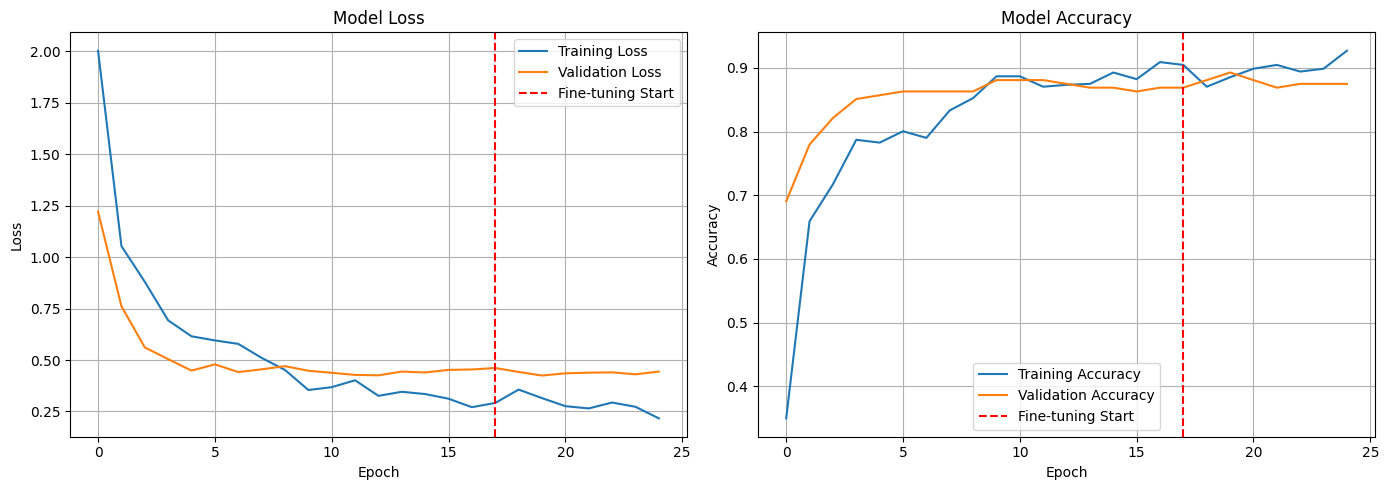

In [ ]:
def plot_training_history(history1, history2=None):
    """Plot training and validation metrics"""
    # Combine histories if fine-tuning was done
    if history2:
        history = {
            'loss': history1.history['loss'] + history2.history['loss'],
            'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
            'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
            'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy']
        }
        phase1_epochs = len(history1.history['loss'])
    else:
        history = history1.history
        phase1_epochs = None
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Loss
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    if phase1_epochs:
        axes[0].axvline(x=phase1_epochs-1, color='r', linestyle='--', label='Fine-tuning Start')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot Accuracy
    axes[1].plot(history['accuracy'], label='Training Accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
    if phase1_epochs:
        axes[1].axvline(x=phase1_epochs-1, color='r', linestyle='--', label='Fine-tuning Start')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history1, history2)

## Model Evaluation on Test Set

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Evaluating model on test set...



Test Loss: 0.6878
Test Accuracy: 0.8333



1/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


2/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


3/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step 


4/7 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


5/7 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


6/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step



=== Classification Report ===
                            precision    recall  f1-score   support

                 Baby Care       0.88      0.70      0.78        30
  Beauty and Personal Care       0.88      0.73      0.80        30
                 Computers       0.86      0.80      0.83        30
Home Decor & Festive Needs       0.74      0.87      0.80        30
           Home Furnishing       0.78      0.83      0.81        30
          Kitchen & Dining       0.80      0.93      0.86        30
                   Watches       0.94      0.97      0.95        30

                  accuracy                           0.83       210
                 macro avg       0.84      0.83      0.83       210
              weighted avg       0.84      0.83      0.83       210



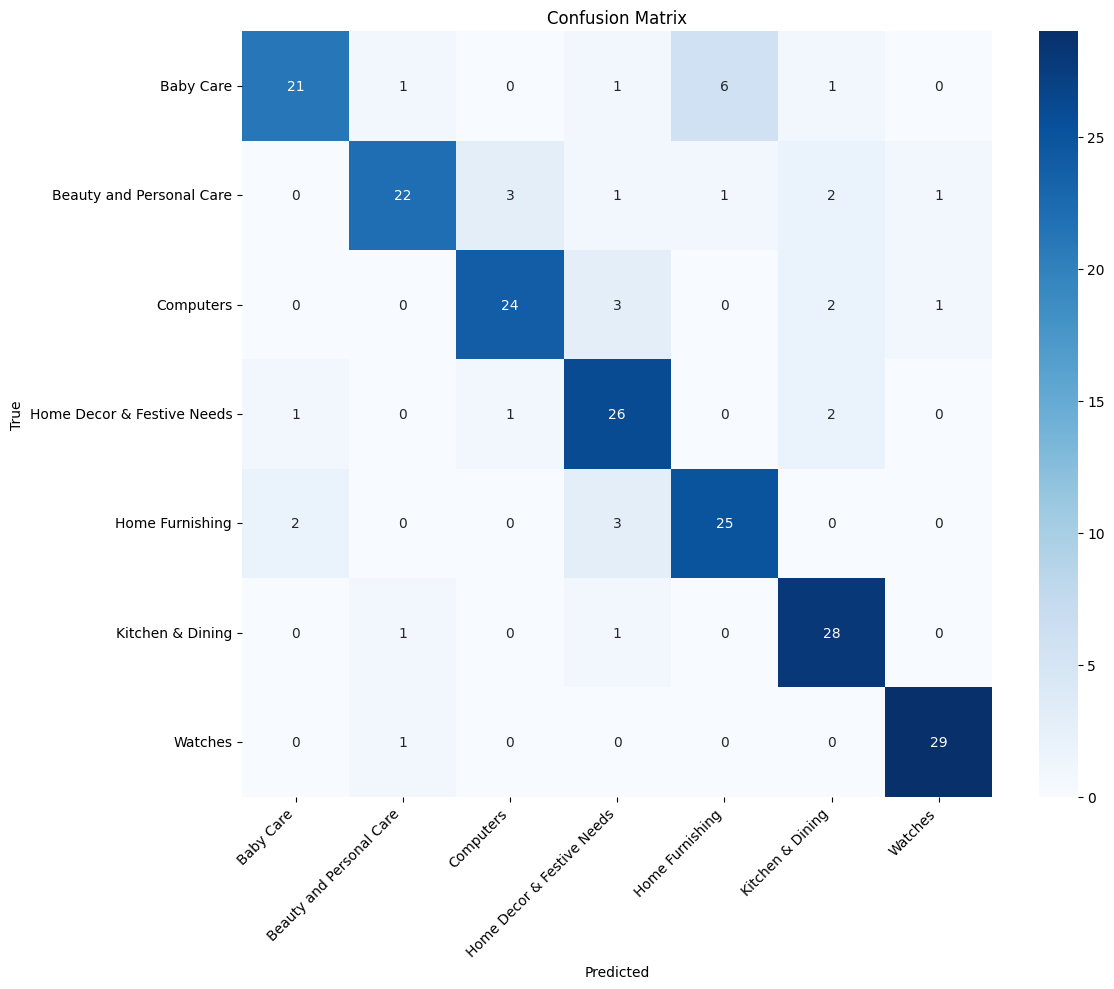

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Sample Predictions Visualization

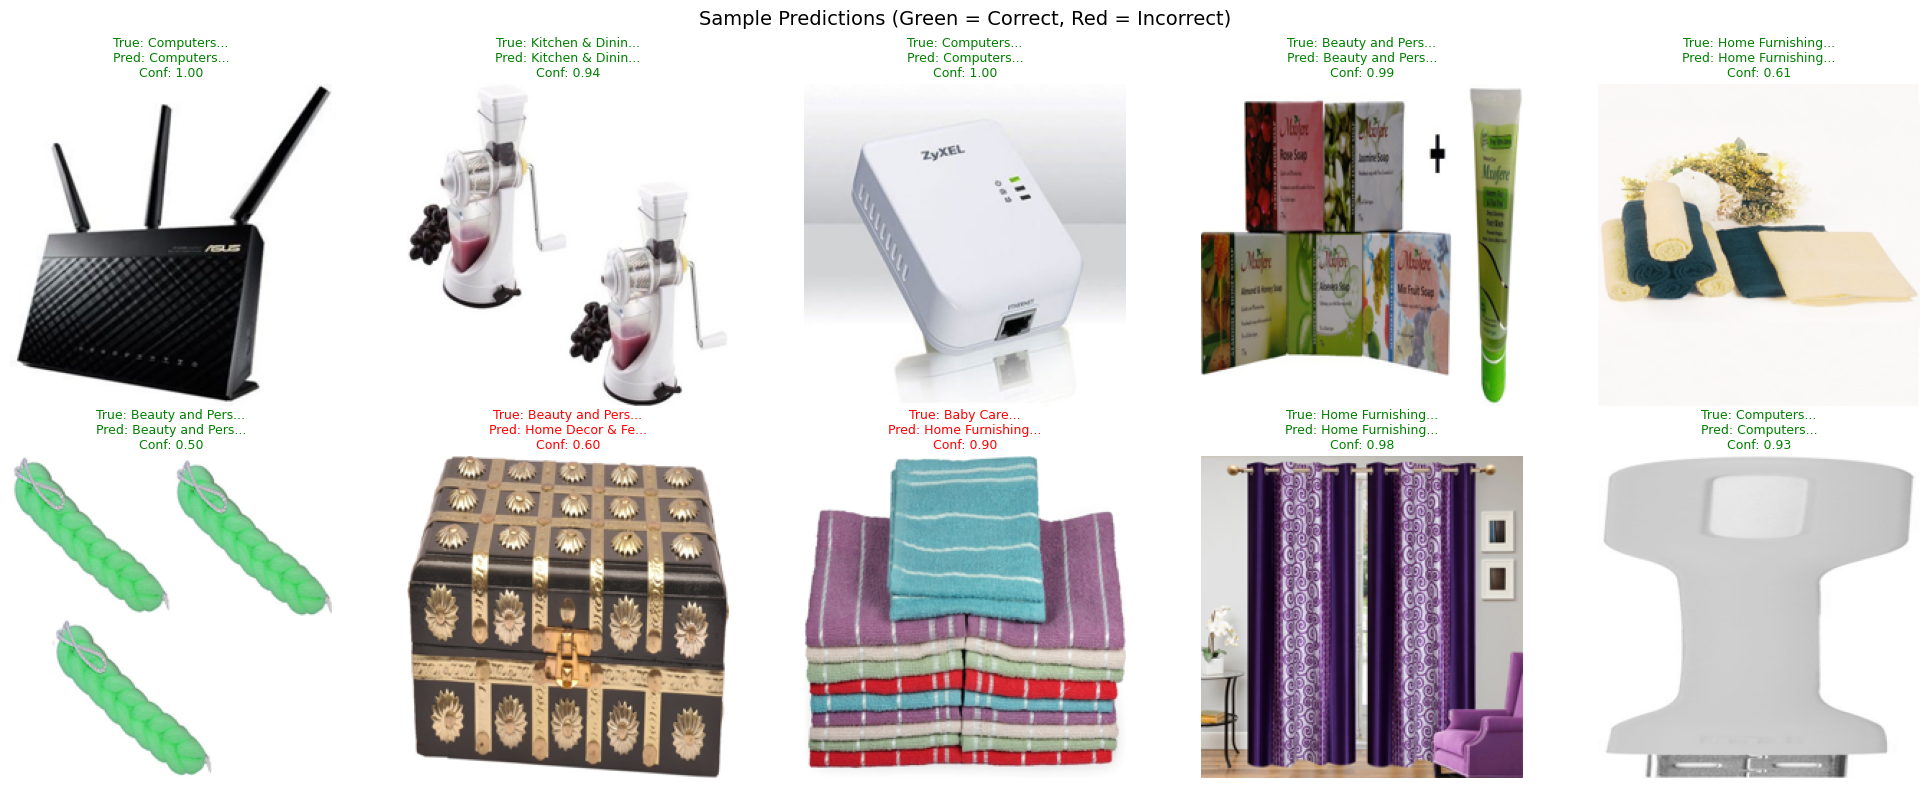

In [ ]:
# Visualize some predictions
n_samples = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Get random indices
indices = np.random.choice(len(X_test), n_samples, replace=False)

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.imshow(X_test[idx].astype(np.uint8))
    
    true_label = le.classes_[y_true[idx]]
    pred_label = le.classes_[y_pred[idx]]
    confidence = y_pred_proba[idx][y_pred[idx]]
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label[:15]}...\nPred: {pred_label[:15]}...\nConf: {confidence:.2f}', 
                 color=color, fontsize=9)
    ax.axis('off')

plt.suptitle('Sample Predictions (Green = Correct, Red = Incorrect)', fontsize=14)
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates supervised image classification using CNN with transfer learning and data augmentation:

1. **Transfer Learning**: Using VGG16 pre-trained on ImageNet allows us to leverage learned features without training from scratch.

2. **Data Augmentation**: Random transformations (flip, rotation, zoom, contrast) help prevent overfitting and improve generalization.

3. **Two-Phase Training**:
   - Phase 1: Train only the classification head with frozen base model
   - Phase 2: Fine-tune the last few layers of the base model

4. **Results**: The model achieves reasonable accuracy on the product classification task, demonstrating that image-based product categorization is feasible.

5. **Potential Improvements**:
   - Increase dataset size with more augmentation
   - Try different architectures (ResNet, EfficientNet)
   - Implement multimodal approach combining image and text features
   - Use cross-validation for more robust evaluation